# Jupyter Example for HERMES

In [8]:
import astropy.units as u
import numpy as np
import healpy
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams

# Visualization of runs

In [2]:
HermesRuns = '/mnt/c/Users/pedro/OneDrive/Escritorio/'

MinEnergy = 10  # GeV
MaxEnergy = 1e6  # GeV
E_points = 50
E = np.logspace(np.log10(MinEnergy), np.log10(MaxEnergy), E_points)

In [3]:
HI_hdulist = pyfits.open(HermesRuns + "VariableMin-Abs_HI_nside256-Inter.fits.gz") 
n_ext_HI = len(HI_hdulist)
first_hdu_HI = HI_hdulist[0]
first_hdu_header_HI = first_hdu_HI.header

index = 20 ## Energy index
current_hdu = HI_hdulist[index+1]
current_header = current_hdu.header
#print(current_header)
nside = current_header['NSIDE']
npix = healpy.nside2npix(nside)
print(nside)
print(npix)
HI_map = np.zeros(npix)
HI_map_data = np.array(current_hdu.data)
HI_map[:] = HI_map_data[:]
print(HI_map.shape)

256
786432
(786432,)


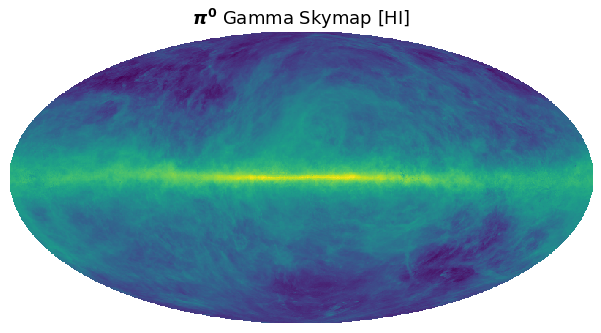

In [23]:
healpy.mollview(np.log(np.abs(HI_map)), cbar=False, title=r'$\pi^0$ Gamma Skymap [HI]')
#healpy.mollview(HI_map, cbar=False, title=r"$\pi^0$ Gamma Skymap [HI]")
#plt.savefig("pi0_mollview_HI_nside{}.pdf".format(nside), dpi=300)

In [4]:
H2_hdulist = pyfits.open(HermesRuns + "VariableMin-Abs_H2_nside256-Inter.fits.gz")  #Break
n_ext_H2 = len(H2_hdulist)
first_hdu_H2 = H2_hdulist[0]
first_hdu_header_H2 = first_hdu_H2.header

current_hdu = H2_hdulist[index+1]
current_header = current_hdu.header
#print(current_header)
nside = current_header['NSIDE']
npix = healpy.nside2npix(nside)
print(nside)
print(npix)
H2_map = np.zeros(npix)
H2_map_data = np.array(current_hdu.data)
H2_map[:] = H2_map_data[:]
print(H2_map.shape)

256
786432
(786432,)


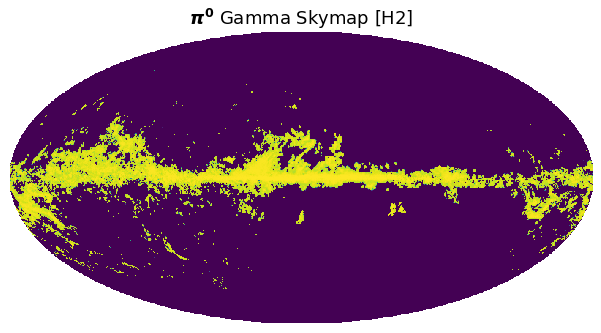

In [22]:
healpy.mollview(H2_map, cbar=False, norm="hist", title=r"$\pi^0$ Gamma Skymap [H2]")
#plt.savefig("pi0_mollview_H2_nside{}_GC_v2.pdf".format(nside), dpi=300)

# Plotting spectrum!

In [5]:
def rectangular_mask_symmetric(nside,lowb_North,highb_North,lowb_South,highb_South,lowl,highl):
    # moving to radiants
    lowb_North = lowb_North/180.*np.pi
    lowb_South = lowb_South/180.*np.pi
    lowl= lowl/180.*np.pi
    highb_North = highb_North/180.*np.pi
    highb_South = highb_South/180.*np.pi
    highl= highl/180.*np.pi
    npix=12*nside**2
    listpix = np.arange(npix)
    theta,phi = healpy.pixelfunc.pix2ang(nside,listpix, nest=False, lonlat=False)
    b = np.pi/2.-theta
    l = phi
    mask = []
    for i in np.arange(npix):
        if(l[i]>np.pi):
            l[i]-=2.*np.pi
        if((((b[i] >= lowb_North) and (b[i] <= highb_North) ) or ( (b[i] >= lowb_South) and (b[i] <= highb_South))) and ((l[i] >= lowl) and (l[i] <= highl) or (l[i] >= -highl) and (l[i] <= -lowl))):
            mask.append(1)
        else:
            mask.append(0)
    return mask



def calc_mean_flux(hdulist, nside, mask):
    energies = np.asarray([float(hdulist[index+1].header['ENERGY'])/GeV_unit for index in range(n_ext_HI-1)])
    fluxesMatrix = np.zeros(( healpy.nside2npix(nside),n_ext_HI-1))
    for index in range(n_ext_HI-1):
        fluxesMatrix[:,index] = np.asarray([hdulist[index+1].data])
    fluxes = np.asarray([ np.sum(fluxesMatrix[:,index]*mask[:])/np.sum(mask[:]) for  index in range(n_ext_HI-1)])
    #fluxes = fluxes/base_units
    return energies, fluxes




use_unit = "GeV"
myGeV = u.Quantity(1, use_unit)
GeV_unit = float(myGeV.unit.si.scale)
Hermes_units = u.Quantity(1, "GeV^-1 m^-2 s^-1 sr^-1")
use_units = "GeV^-1 cm^-2 s^-1 sr^-1"
skymap_units = u.Quantity(1, use_units)
base_units = Hermes_units.to(skymap_units)
spectral_units = float(base_units.value)
#print(GeV_unit)
#print(spectral_units)

In [6]:
### TIBET and ARGO data for 25º < l < 100º and |b| < 5
folderDR = '/home/tospines/PROJECTS/Gamma_InhomogeneousDiff/'

data = folderDR + '/TIBET_data.txt'
EmeanTIB, ElowTIB, EmaxTIB = np.loadtxt(data,skiprows=0,usecols=(0, 1, 2), unpack=True)*1e3 # TeV -- >GeV
FluxTIB, FluxlowTIB, FluxmaxTIB = np.loadtxt(data,skiprows=0,usecols=(3, 4, 5), unpack=True)*1e-3 # dN/dE TeV{-1} --> GeV{-1}

data = folderDR + '/ARGO_data.txt'
EmeanARG = np.loadtxt(data,skiprows=0,usecols=(0), unpack=True)*1e3 # TeV -- >GeV
FluxARG, FluxlowARG, FluxmaxARG = np.loadtxt(data,skiprows=0,usecols=(1, 2, 3), unpack=True)#*(EmeanARG**-2.7)

data = folderDR + '/LHAASO_25-100_Prel.txt'
EmeanL = np.loadtxt(data,skiprows=0,usecols=(0), unpack=True)*1e3 # TeV -- >GeV
FluxL, FluxlowL, FluxmaxL = np.loadtxt(data,skiprows=0,usecols=(1, 2, 3), unpack=True)*1e3 # Flux in E^2*Flux

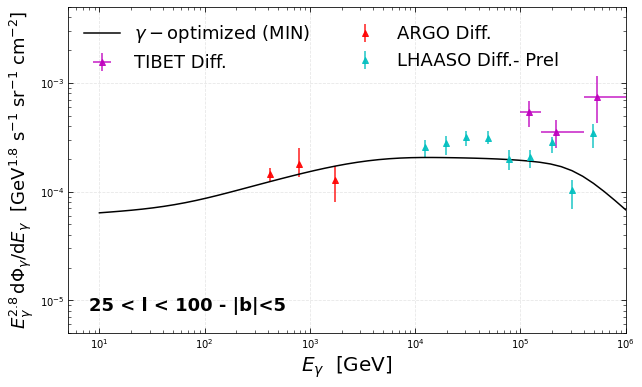

In [9]:
ei = 0.8

fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
rc('font', size=18)

def plot_spectrum(hdulist, label, nside, mask, color, marker='-'):
    energies, fluxes = calc_mean_flux(hdulist, nside, mask)
    plt.plot(energies, fluxes*energies**(2.+ei) * spectral_units, marker, label=label, color=color)

newMask = rectangular_mask_symmetric(nside, 0., 5., -5., 0., 25., 100.)

plt.errorbar(EmeanTIB, FluxTIB*(EmeanTIB**(2+ei)), yerr = [(np.sqrt( ((FluxTIB-FluxlowTIB)/FluxTIB)**2 + ((EmeanTIB-ElowTIB)/EmeanTIB)**2))*FluxTIB*(EmeanTIB**(2+ei)), (np.sqrt( ((FluxmaxTIB-FluxTIB)/FluxTIB)**2 + ((EmeanTIB-ElowTIB)/EmeanTIB)**2)) * FluxTIB*(EmeanTIB**(2+ei))], xerr = [EmeanTIB-ElowTIB, EmaxTIB-EmeanTIB], fmt= 'm^', alpha = 0.9, label = 'TIBET Diff.') 
plt.errorbar(EmeanARG, FluxARG*(EmeanARG**(ei-0.7)), yerr = [(FluxARG-FluxlowARG)*(EmeanARG**(ei-0.7)), (FluxmaxARG-FluxARG)*(EmeanARG**(ei-0.7))], fmt= 'r^', alpha = 0.9, label = 'ARGO Diff.')
plt.errorbar(EmeanL, FluxL*EmeanL**ei, yerr = [(FluxL-FluxlowL)*EmeanL**ei, (FluxmaxL-FluxL)*EmeanL**ei], fmt= 'c^', alpha = 0.9, label = 'LHAASO Diff.- Prel')

Tot_sum = calc_mean_flux(HI_hdulist, nside, newMask)[1] + calc_mean_flux(H2_hdulist, nside, newMask)[1] 
plt.plot(E, Tot_sum*E**(2.+ei) * spectral_units, color='k', label=r'$\gamma-$optimized (MIN)')

plt.legend(frameon = False, ncol = 2, prop={'weight':'normal'}, loc = 'upper left')

#plt.title("Diffuse gamma-ray spectrum", fontsize=18)
plt.xlabel("$E_\gamma$  [GeV]", fontsize=20)
plt.ylabel("$E_\gamma^{2.8}\, \mathrm{d}\Phi_\gamma / \mathrm{d} E_\gamma$  [GeV$^{1.8}$ s$^{-1}$ sr$^{-1}$ cm$^{-2}$]", fontsize=18)

ax.tick_params(which='minor', direction='in', axis='both', bottom=True, top=True, left=True, right=True, length=3)
ax.tick_params(which='major', direction='in', axis='both', bottom=True, top=True, left=True, right=True, length=5)
plt.xscale("log")
plt.yscale("log")
plt.grid(color= '0.9', linestyle='dashed', axis = 'both')

plt.text(8, 8.e-6, '25 < l < 100 - |b|<5', weight='bold')
plt.xlim(left = 5, right = 1e6)
plt.ylim(bottom = 5.e-6, top = 5.e-3)

#plt.savefig(HermesRuns + "/Gamma-emission-ARGO_TIBET_LHAASO.png", dpi=250)  
#plt.savefig(HermesRuns + "/Gamma-emission-ARGO_TIBET_LHAASO.pdf", dpi=250)  
plt.show()